* Date: 16-06-2025
* Student name: Chaw Su Su Thinn
* Student ID: c0916347

## Objective

You are given a dataset of used car listings. Your task is to build multiple regression models to predict the selling price of used cars based on features like age, brand, kilometers driven, fuel type, etc.
Compare the models based on performance, and save the best model for future deployment.

## Dataset

The dataset used in this project is sourced from the Kaggle competition: [Playground Series - Season 4, Episode 9](https://www.kaggle.com/competitions/playground-series-s4e9/overview).

It includes training and testing sets related to used car listings, designed for regression-based price prediction. 

Each row represents an individual car listing with several key attributes:

* **id**: Unique identifier for each listing
* **brand**: Car manufacturer name
* **model**: Specific model of the vehicle
* **model_year**: Manufacturing year of the vehicle
* **milage**: Total kilometers driven
* **fuel_type**: Type of fuel used (gasoline, diesel, electric, hybrid)
* **engine**: Engine specifications
* **transmission**: Transmission type (automatic, manual, etc.)
* **ext_col**: Exterior color
* **int_col**: Interior color
* **accident**: Whether the car has a history of accidents or damage
* **clean_title**: Indicates if the vehicle holds a clean title, which can impact the vehicle's resale value and legal status
* **price**: Resale price of the car (target variable, only in train.csv)

## Import libraries

In [1]:
%pip install -r "../requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import date
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import math
import pickle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Data Preprocessing

### 1.1 Load the dataset and perform basic cleaning (handle missing values, duplicates).

In [3]:
# Define file paths of the datasets
train_path = "../dataset/train.csv"
test_path = "../dataset/test.csv"

# Load datasets into pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
# Display first 5 rows
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [5]:
# Display first 5 rows
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [6]:
# Check data types and non-null counts
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [7]:
# Check data types and non-null counts
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [8]:
# Check statistics summary
train_df.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [9]:
# Check statistics summary
test_df.describe()

,id,model_year,milage
count,125690.000000,125690.000000,125690.000000
mean,251377.500000,2015.797526,66042.581510
std,36283.722005,5.673797,50223.858435
min,188533.000000,1974.000000,100.000000
25%,219955.250000,2013.000000,24500.000000
50%,251377.500000,2017.000000,57500.000000
75%,282799.750000,2020.000000,95798.000000
max,314222.000000,2024.000000,405000.000000


In [10]:
# Check missing values for each column
train_df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [11]:
# Check missing values for each column
test_df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

**Observations from initial analysis of both datasets:**

* The training set contains 188,533 records, while the test set contains 125,690 records.

* From train_df,

    * There are 5083 missing values in `fuel_type` and 2452 in `accident`. 

    * Meanwhile, `clean_title` has 21419 missing records. I will further analyze whether to drop these records or replace them. 

* From test_df,

    * 3383 missing `fuel_type` records and 1632 missing `accident` records.

    * Whereas, there are 14239 missing records in `clean_title`.

<Axes: >

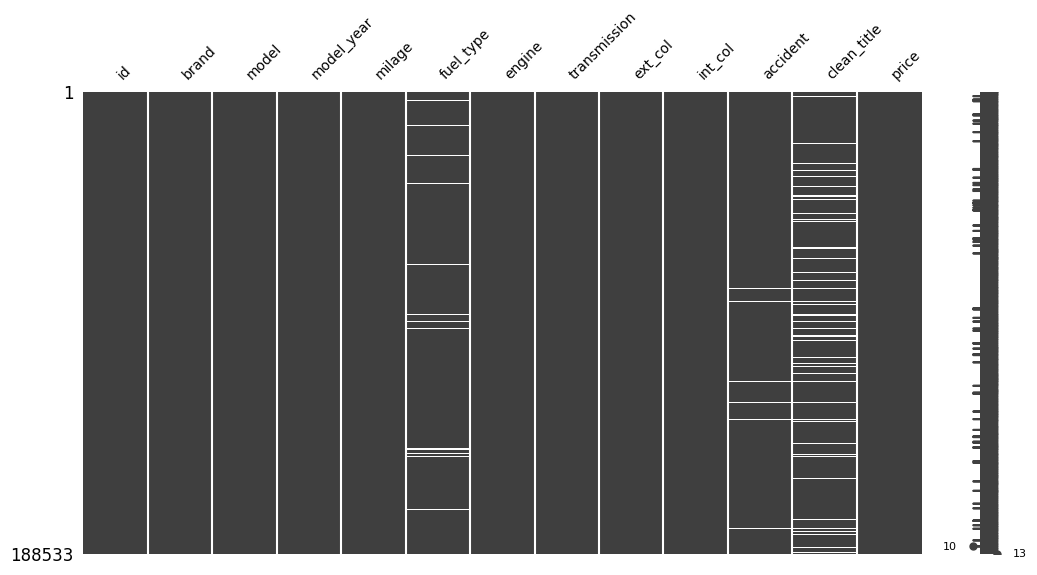

In [12]:
# Visualize missing values
msno.matrix(train_df, figsize=(12, 6), fontsize=10)

<Axes: >

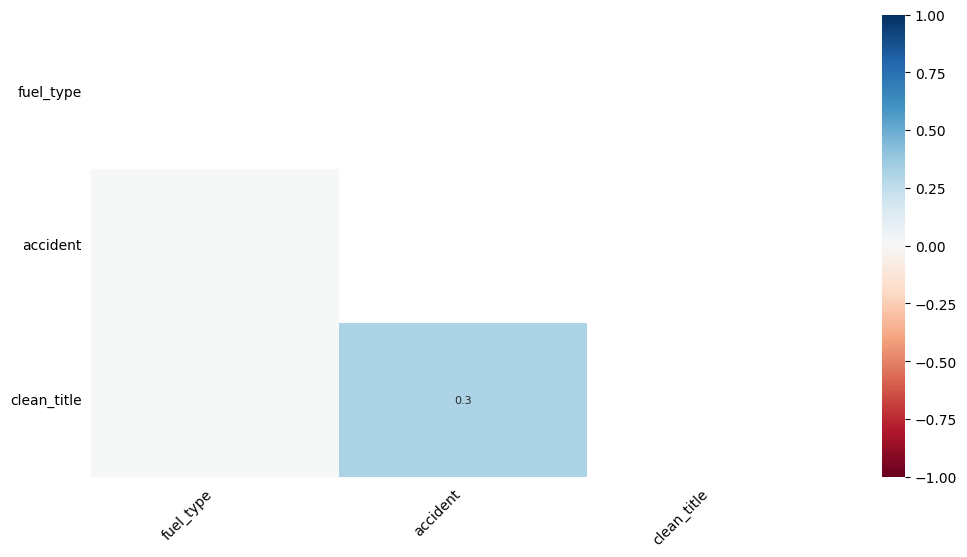

In [13]:
msno.heatmap(train_df, figsize=(12, 6), fontsize=10)

**Observations from missing value matrix and heatmap:**

* The matrix shows missing values mostly occur independently across `fuel_type`, `accident`, and `clean_title`.

* From the heatmap, only `accident` and `clean_title` have a weak correlation (0.3), meaning some overlap in missing rows, but nothing strong enough to suggest joint imputation.

* So, I’ll handle missing values for each column separately.

In [14]:
# Verify unique values in the missing columns
missing_columns = train_df.columns[train_df.isna().any()]

for col in missing_columns:
    print(f"Unique values count of {col}: {train_df[col].nunique()}")
    print(f"{train_df[col].unique()}\n")

Unique values count of fuel_type: 7
['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']

Unique values count of accident: 2
['None reported' 'At least 1 accident or damage reported' nan]

Unique values count of clean_title: 1
['Yes' nan]



In [15]:
for col in missing_columns:
    print(f"Value counts of {col}: {train_df[col].value_counts()}\n")

Value counts of fuel_type: fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

Value counts of accident: accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

Value counts of clean_title: clean_title
Yes    167114
Name: count, dtype: int64



In [16]:
# Strip and lower model values
original_n_unique = train_df['model'].nunique()
cleaned_n_unique = train_df['model'].astype(str).str.strip().str.lower().nunique()

print(f"Before cleaning: {original_n_unique} unique values")
print(f"After cleaning:  {cleaned_n_unique} unique values")

Before cleaning: 1897 unique values
After cleaning:  1893 unique values


**Observations from unqiue values and counts:**

* All three columns that have missing values are categorical.

    * `fuel_type` has 7 unique values. Among them, `–` (781 records) and `not supported` (15 records) don't indicate valid fuel types. So, I’ll treate them as invalid fuel types alongside the missing values, and replace with `Unknown`. 

    * `accident` has only two values, `None reported` and `At least 1 accident or damage reported`. Since `None Reported` has 144,514 rows, I will leave them as-is, and I’ll fill missing values with `Unknown`.

    * `clean_title` only has `Yes`. Since there’s no alternative value, I’ll treat missing records as `Unknown`.

**Strategy for cleaning and standardizing cols**

* I created a function that will

    * strip white spaces and lowercase everything inside categorical columns

    * standardize `fuel_type`, `accident` and `clean_title` columns as I stated above.

* After that, I called that function using both train_df and test_df to get a return of cleaned datasets.

In [17]:
# Create function to clean and standardize columns
def clean_categorical_columns(df):
    df = df.copy()

    # Define cat cols
    categorical_cols = df.select_dtypes(include=['object', 'string']).columns

    # Strip, lowercase, and clean string 'nan'
    for col in categorical_cols:
        df[col] = df[col].astype(str).str.strip().str.lower()
        df[col] = df[col].replace('nan', np.nan)  # Convert string 'nan' to real np.nan
    
    # Define valid fuel types
    valid_fuels = {'gasoline', 'hybrid', 'e85 flex fuel', 'plug-in hybrid'}

    # Replace invalid or missing fuel_type with 'unknown'
    if 'fuel_type' in df.columns:
        df['fuel_type'] = df['fuel_type'].apply(lambda x: x if x in valid_fuels else 'unknown')

    # Replace missing values in 'accident'
    if 'accident' in df.columns:
        df['accident'] = df['accident'].fillna('unknown')
        df['accident'] = df['accident'].replace({
            'at least 1 accident or damage reported': 'reported',
            'none reported': 'none'
        })

    # Replace missing values in 'clean_title'
    if 'clean_title' in df.columns:
        df['clean_title'] = df['clean_title'].fillna('unknown')

    return df

In [18]:
# Call function to clean both datasets
train_df = clean_categorical_columns(train_df)
test_df = clean_categorical_columns(test_df)

In [19]:
# Verify again
print(train_df.isna().sum())
print(test_df.isna().sum())

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64
id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


In [20]:
# Check full row duplicates
print(train_df.duplicated().sum())

0


In [21]:
# Define columns to check (except id and price)
to_check = train_df.columns.difference(['id', 'price'])

# Check count of every duplicated row including first occurrence
print(train_df.duplicated(subset=to_check, keep=False).sum()) 

# Print duplicated rows
train_df[train_df.duplicated(subset=to_check, keep=False)]

2


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
58891,58891,ram,1500 laramie,2022,76249,gasoline,5.7l v8 16v mpfi ohv,8-speed automatic,diamond black,black,none,yes,49685
75505,75505,ram,1500 laramie,2022,76249,gasoline,5.7l v8 16v mpfi ohv,8-speed automatic,diamond black,black,none,yes,36250


In [22]:
# Keep the first unique row, and drop the rest
train_df = train_df[~train_df.duplicated(subset=to_check, keep='first')]

# Check duplicate counts again
print(train_df.duplicated(subset=to_check, keep=False).sum()) 

0


**Observations from duplicate checks:**

* Using `train_df.duplicated().sum()`, I found 0 exact duplicates across all columns.

* However, when I checked a subset of columns ('brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'), and left target column behind, I found 2 duplicated records.

* When I print those records, I found that all subset columns have same vlaues, except for id and price. 

* So, I kept only the first unique row, and dropped the second record. After that, I checked the dupolicate counts again, and found 0.

### 1.2 Create a new feature: `car_age = current_year - year`.

In [23]:
# Get current year using date.today().year
current_year = date.today().year
print(current_year)

2025


In [24]:
# Check unique values of model year
train_df['model_year'].unique()

array([2007, 2002, 2017, 2021, 2018, 2016, 2020, 2015, 2011, 2013, 2023,
       2019, 2012, 2014, 2008, 2009, 2022, 2003, 2005, 2001, 2006, 2000,
       2010, 2004, 1997, 1998, 1999, 1994, 1993, 1996, 1995, 2024, 1974,
       1992])

In [25]:
# Create new column to calculate car age
train_df['car_age'] = current_year - train_df['model_year']
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age
0,0,mini,cooper s base,2007,213000,gasoline,172.0hp 1.6l 4 cylinder engine gasoline fuel,a/t,yellow,gray,none,yes,4200,18
1,1,lincoln,ls v8,2002,143250,gasoline,252.0hp 3.9l 8 cylinder engine gasoline fuel,a/t,silver,beige,reported,yes,4999,23
2,2,chevrolet,silverado 2500 lt,2002,136731,e85 flex fuel,320.0hp 5.3l 8 cylinder engine flex fuel capab...,a/t,blue,gray,none,yes,13900,23
3,3,genesis,g90 5.0 ultimate,2017,19500,gasoline,420.0hp 5.0l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,black,black,none,yes,45000,8
4,4,mercedes-benz,metris base,2021,7388,gasoline,208.0hp 2.0l 4 cylinder engine gasoline fuel,7-speed a/t,black,beige,none,yes,97500,4


In [26]:
# Do the same for test_df
test_df['car_age'] = current_year - test_df['model_year']
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,car_age
0,188533,land,rover lr2 base,2015,98000,gasoline,240.0hp 2.0l 4 cylinder engine gasoline fuel,6-speed a/t,white,beige,none,yes,10
1,188534,land,rover defender se,2020,9142,hybrid,395.0hp 3.0l straight 6 cylinder engine gasoli...,8-speed a/t,silver,black,none,yes,5
2,188535,ford,expedition limited,2022,28121,gasoline,3.5l v6 24v pdi dohc twin turbo,10-speed automatic,white,ebony,none,unknown,3
3,188536,audi,a6 2.0t sport,2016,61258,gasoline,2.0 liter tfsi,automatic,silician yellow,black,none,unknown,9
4,188537,audi,a6 2.0t premium plus,2018,59000,gasoline,252.0hp 2.0l 4 cylinder engine gasoline fuel,a/t,gray,black,none,yes,7


### 1.3 Drop irrelevant features like `car_name` if present.

In [27]:
# Check the column names
print(train_df.columns)
print(test_df.columns)

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'car_age'],
      dtype='object')
Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'car_age'],
      dtype='object')


In [28]:
# Drop irrelevant columns
train_df.drop(['model_year', 'id'], axis=1, inplace=True, errors='ignore')
test_df.drop(['model_year', 'id'], axis=1, inplace=True, errors='ignore')

In [29]:
# Verify columns again
print(train_df.columns)
print(test_df.columns)

Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'car_age'],
      dtype='object')
Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'car_age'],
      dtype='object')


### 1.4 Convert categorical variables using One-Hot Encoding or Label Encoding.

**Strategy for high-cardinality categorical features**

* For high-cardinality categorical features like `brand`, `model`, `engine`, etc., I decided to keep only the top frequent values.

* Everything outside the top N (based on frequency) is grouped under `'other'` to reduce dimensionality and noise.

* This helps control the number of one-hot encoded columns and avoids overfitting from rare categories.

* I applied the same logic consistently across `transmission`, `ext_col`, and `int_col` as well, just to keep the encoding space clean.

In [30]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

print(train_df[categorical_cols].nunique().sort_values(ascending=False))

model           1893
engine          1117
ext_col          317
int_col          152
brand             57
transmission      51
fuel_type          5
accident           3
clean_title        2
dtype: int64


#### Filter and group 'brand'

**Approach for `brand`**

* I checked the frequency of each brand and found that only a handful have strong representation in the data.

* To simplify the encoding and avoid overfitting from rare brands, I grouped all brands with less than 2000 records into a single category called `'other'`.

* This keeps the one-hot encoded space cleaner and focuses the model on brands that actually have enough signal.

* I applied the same logic to both train and test sets to keep it consistent.

In [31]:
print("Top values (brand):")
print(train_df['brand'].value_counts().head(10))

print("\nRare or weird values (brand):")
print(train_df['brand'].value_counts().tail(10))

Top values (brand):
brand
ford             23088
mercedes-benz    19172
bmw              17028
chevrolet        16335
audi             10887
porsche          10612
land              9525
toyota            8850
lexus             8643
jeep              6474
Name: count, dtype: int64

Rare or weird values (brand):
brand
lotus       52
fiat        44
saab        22
karma       17
suzuki       8
plymouth     7
polestar     7
bugatti      7
smart        3
maybach      3
Name: count, dtype: int64


In [32]:
# Define threshold for filtering common brands
threshold = 2000

# Get frequency count of each brand in training set
brand_counts = train_df['brand'].value_counts()

# Get list of brands that meet or exceed the threshold
common_brands = brand_counts[brand_counts >= threshold].index.tolist()

# Replace rare brands with 'other' in both train and test sets
train_df['brand_grp'] = train_df['brand'].apply(lambda x: x if x in common_brands else 'other')
test_df['brand_grp'] = test_df['brand'].apply(lambda x: x if x in common_brands else 'other')

In [33]:
# Verify the new cols
print(train_df['brand_grp'].value_counts())
print("------------------")
print(test_df['brand_grp'].value_counts())

brand_grp
ford             23088
mercedes-benz    19172
bmw              17028
chevrolet        16335
other            15256
audi             10887
porsche          10612
land              9525
toyota            8850
lexus             8643
jeep              6474
cadillac          4674
ram               4248
nissan            3930
tesla             3738
infiniti          3276
gmc               3215
dodge             3133
mazda             2719
kia               2497
lincoln           2423
subaru            2381
acura             2282
honda             2101
hyundai           2045
Name: count, dtype: int64
------------------
brand_grp
ford             15265
mercedes-benz    12875
bmw              11286
chevrolet        10698
other            10375
audi              7289
porsche           7153
land              6348
toyota            6084
lexus             5729
jeep              4412
cadillac          3059
ram               2753
nissan            2674
tesla             2387
infiniti       

#### Filter and group 'model'

**Strategy for `model`**

* I extracted the first two tokens from the original `model` name to create a simplified `model_base`, since full model names are too detailed and inconsistent.

* From that, I selected the top 100 most frequent `model_base` values based on their counts in the training set.

* All other less common or noisy model names were grouped under `'other'` to reduce dimensionality and avoid overfitting.

* I applied this grouping to both train and test sets.

In [34]:
# Extract first two tokens as model_base
train_df['model_base'] = train_df['model'].str.split().str[:2].str.join(' ')
test_df['model_base'] = test_df['model'].str.split().str[:2].str.join(' ')

# Select top 100 frequent models from model_base
top_models = train_df['model_base'].value_counts().nlargest(100).index

# Group model_base
train_df['mdl_grp'] = train_df['model_base'].apply(lambda x: x if x in top_models else 'other')
test_df['mdl_grp'] = test_df['model_base'].apply(lambda x: x if x in top_models else 'other')

In [35]:
# Verify the new cols
print(train_df['mdl_grp'].value_counts())
print("------------------")
print(test_df['mdl_grp'].value_counts())

mdl_grp
other               90901
rover range          7647
911 carrera          3905
f-150 xlt            3228
e-class e            3170
                    ...  
escalade premium      422
ls 460                421
a8 l                  417
mx-5 miata            416
wrangler sahara       411
Name: count, Length: 101, dtype: int64
------------------
mdl_grp
other               61179
rover range          5148
911 carrera          2552
f-150 xlt            2125
e-class e            2034
                    ...  
escalade premium      279
mx-5 miata            268
golf gti              265
mustang premium       260
fusion se             259
Name: count, Length: 101, dtype: int64


#### Extract new features from 'engine'

**Strategy for parsing `engine`**

* The `engine` column contains free-text data with mixed formats like horsepower, engine size, cylinder count, and occassionally fuel type.

* I wrote a custom function to extract structured features from that text:

  * `engine_hp` (e.g. 450hp)
  * `engine_size` (e.g. 4.0L)
  * `engine_cyl` (e.g. 8 cylinder)
  * `engine_fuel_type` (if text contains "engine" or "motor", take the trailing token)

* For any patterns not matched, I left the value as `None` so I can handle missing values explicitly later.

* I applied this transformation to both train and test sets to create clean numeric features out of messy text.

In [36]:
print("Top values (engine):")
print(train_df['engine'].value_counts().head(20))

print("\nRare or weird values (engine):")
print(train_df['engine'].value_counts().tail(20))

Top values (engine):
engine
355.0hp 5.3l 8 cylinder engine gasoline fuel             3462
240.0hp 2.0l 4 cylinder engine gasoline fuel             2902
420.0hp 6.2l 8 cylinder engine gasoline fuel             2841
2.0l i4 16v gdi dohc turbo                               2680
375.0hp 3.5l v6 cylinder engine gasoline fuel            2451
340.0hp 3.0l v6 cylinder engine gasoline fuel            2436
490.0hp 6.2l 8 cylinder engine gasoline fuel             2187
455.0hp 6.2l 8 cylinder engine gasoline fuel             2138
425.0hp 3.0l straight 6 cylinder engine gasoline fuel    2134
300.0hp 3.0l straight 6 cylinder engine gasoline fuel    2084
295.0hp 3.5l v6 cylinder engine gasoline fuel            1917
285.0hp 3.6l v6 cylinder engine gasoline fuel            1910
302.0hp 3.5l v6 cylinder engine gasoline fuel            1895
3.5l v6 24v pdi dohc twin turbo                          1842
301.0hp 4.6l 8 cylinder engine gasoline fuel             1578
5.7l v8 16v mpfi ohv                      

In [37]:
def extract_engine_features(val):
    val = str(val).lower()
    
    hp_match = re.search(r'(\d+\.?\d*)hp', val)
    l_match = re.search(r'(\d+\.?\d*)l', val)
    cyl_match = re.search(r'(\d+) cylinder', val)
    
    fuel_type = None
    if 'engine' in val:
        fuel_type = val.split('engine')[-1].strip()
    elif 'motor' in val:
        fuel_type = val.split('motor')[-1].strip()
    
    return pd.Series({
        'engine_hp': float(hp_match.group(1)) if hp_match else None,
        'engine_size': float(l_match.group(1)) if l_match else None,
        'engine_cyl': int(cyl_match.group(1)) if cyl_match else None,
        'engine_fuel_type': fuel_type
    })

In [38]:
# Apply function to extract engine features on train dataset
train_engine_features = train_df['engine'].apply(extract_engine_features)
train_df = pd.concat([train_df, train_engine_features], axis=1)

# Apply function to extract engine features on test dataset
test_engine_features = test_df['engine'].apply(extract_engine_features)
test_df = pd.concat([test_df, test_engine_features], axis=1)

In [39]:
# Verify the columns
print(train_df.columns)
print(test_df.columns)

Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'car_age',
       'brand_grp', 'model_base', 'mdl_grp', 'engine_hp', 'engine_size',
       'engine_cyl', 'engine_fuel_type'],
      dtype='object')
Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'car_age', 'brand_grp',
       'model_base', 'mdl_grp', 'engine_hp', 'engine_size', 'engine_cyl',
       'engine_fuel_type'],
      dtype='object')


In [40]:
# Verify the values
print(train_df[['engine_hp', 'engine_size', 'engine_cyl', 'engine_fuel_type']].nunique())
print(test_df[['engine_hp', 'engine_size', 'engine_cyl', 'engine_fuel_type']].nunique())

engine_hp           348
engine_size          61
engine_cyl            7
engine_fuel_type     11
dtype: int64
engine_hp           347
engine_size          61
engine_cyl            7
engine_fuel_type     11
dtype: int64


In [41]:
print(train_df['engine_hp'].value_counts())

engine_hp
300.0    5416
355.0    4433
420.0    4020
240.0    3634
400.0    3518
         ... 
141.0       2
70.0        1
111.0       1
78.0        1
313.0       1
Name: count, Length: 348, dtype: int64


In [42]:
print(train_df['engine_size'].value_counts())

engine_size
3.0    23929
3.5    21216
2.0    20486
6.2    10831
4.0    10592
       ...  
1.2       26
8.0       20
8.4       18
7.4       16
1.0        1
Name: count, Length: 61, dtype: int64


In [43]:
print(train_df['engine_cyl'].value_counts())

engine_cyl
6.0     66301
8.0     52588
4.0     29051
12.0     1266
10.0      698
5.0       627
3.0       147
Name: count, dtype: int64


In [44]:
print(train_df['engine_fuel_type'].value_counts())

engine_fuel_type
gasoline fuel                    136161
flex fuel capability               5168
electric fuel system               4949
diesel fuel                        3691
gasoline/mild electric hybrid      3573
gas/electric hybrid                1558
plug-in electric/gas                537
- standard                          117
hydrogen fuel                        16
s                                    15
                                      8
Name: count, dtype: int64


**Observations from prased engine features**

* `engine_hp` and `engine_size` contain hundreds of unique values, often repeated in specific increments (e.g., 300.0, 420.0). There are also many sparse or one-off values.

* `engine_cyl` is more structured, with values like 6.0, 8.0, 4.0 helding from 29,000+ to 66,000+ records.

* `engine_fuel_type` has a strong skew toward `'gasoline fuel'`, with a long tail of rare or ambiguous labels (e.g., `'s'`, `'standard'`, `'hydrogen fuel'`).

**Strategy**

* I’m not going to drop any of these immediately. I’ll keep some parsed features for now so I can include them in correlation analysis and see how they relate to the target (`price`).

* Based on that, I’ll decide whether to drop these if they’re redundant and highly correlated with other numerical features.

* As for `engine_fuel_type`, I’m dropping it since it’s too sparse, messy, and redundant, and I’m already using the cleaned `engine` features.

In [45]:
# Drop irrelevant column
train_df.drop(['engine_fuel_type'], axis=1, inplace=True, errors='ignore')
test_df.drop(['engine_fuel_type'], axis=1, inplace=True, errors='ignore')

#### Filter and group 'transmission'

**Strategy for `transmission`**

* The original `transmission` column had inconsistent and noisy labels like `'m/t'`, `'a/t'`, `'manual'`, `'automatic'`, `'cvt'`, etc.

* I simplified this by mapping them into three clean categories: `'manual'`, `'automatic'`, and `'cvt'`.

* Anything that didn’t match those patterns was grouped as `'other'`.

* I will apply `OneHotEncoding` to these at later steps.

* I applied this transformation to both train and test sets.

In [46]:
print("Top values (transmission):")
print(train_df['transmission'].value_counts().head(10))

print("\nRare or weird values (transmission):")
print(train_df['transmission'].value_counts().tail(10))

Top values (transmission):
transmission
a/t                               49904
8-speed a/t                       20652
transmission w/dual shift mode    19255
6-speed a/t                       18044
6-speed m/t                       11998
7-speed a/t                       11124
automatic                         10691
8-speed automatic                  8430
10-speed a/t                       8044
9-speed a/t                        3866
Name: count, dtype: int64

Rare or weird values (transmission):
transmission
8-speed manual                    28
manual                            27
6-speed                           27
2-speed automatic                 22
6 speed at/mt                     20
7-speed dct automatic             18
single-speed fixed gear           16
cvt-f                             15
8-speed at                        13
scheduled for or in production     6
Name: count, dtype: int64


In [47]:
# Define function to group transmission
def simplify_transmission(val):
    val = val.lower()
    if 'manual' in val or 'm/t' in val:
        return 'manual'
    elif 'a/t' in val or 'automatic' in val or 'at' in val:
        return 'automatic'
    elif 'cvt' in val:
        return 'cvt'
    else:
        return 'other'
    
# Apply function on both dataset
train_df['trn_grp'] = train_df['transmission'].apply(simplify_transmission)
test_df['trn_grp'] = test_df['transmission'].apply(simplify_transmission)

In [48]:
# Verify the new cols
print(train_df['trn_grp'].value_counts())
print("------------------")
print(test_df['trn_grp'].value_counts())

trn_grp
automatic    150334
other         19835
manual        16358
cvt            2005
Name: count, dtype: int64
------------------
trn_grp
automatic    100319
other         13237
manual        10785
cvt            1349
Name: count, dtype: int64


#### Filter and group 'ext_col'

**Strategy for `ext_col`**

* The original color values were inconsistent and messy, with variations like `"blue caelum"` vs `"gt silver"` vs `"thunder gray"`.

* I had already cleaned and lowercased all string columns earlier using function `clean_categorical_columns` at step 1.1. 

* I combined train and test color values to get the full distribution and identified the most common base colors like `'black'`, `'white'`, `'gray'`, `'silver'`, `'blue'`, etc.

* Then I created a function to map each color string to one of those base colors using keyword matching.

* If no base color was found in the string, I grouped it as `'other'`.

In [49]:
print("Top values (ext_col):")
print(train_df['ext_col'].value_counts().head(10))

print("\nRare or weird values (ext_col):")
print(train_df['ext_col'].value_counts().tail(10))

Top values (ext_col):
ext_col
black     48687
white     43815
gray      25293
silver    16995
blue      14558
red        9901
green      2698
gold       1668
brown      1162
orange     1139
Name: count, dtype: int64

Rare or weird values (ext_col):
ext_col
aventurine green metallic             7
thunder gray                          7
silky silver                          7
nautical blue pearl                   7
frozen white                          6
dark gray metallic                    6
granite crystal metallic clearcoat    5
blue caelum                           5
gt silver                             5
mango tango pearlcoat                 2
Name: count, dtype: int64


In [50]:
# Combine train and test color values
combined_colors = pd.concat([train_df['ext_col'], test_df['ext_col']], axis=0)

# Extract top 10 most frequent base color keywords
top_colors = combined_colors.value_counts().head(10).index.tolist()

# Flatten to base color groups from common names
ext_base_colors = []
for val in top_colors:
    for token in val.split():
        if token not in ext_base_colors:
            ext_base_colors.append(token)
    if len(ext_base_colors) >= 10:
        break

print("Auto-detected base colors:", ext_base_colors)

Auto-detected base colors: ['black', 'white', 'gray', 'silver', 'blue', 'red', 'green', 'gold', 'brown', 'orange']


In [51]:
# Create function to match into color groups
def match_col_group(val, base_colors):
    val = str(val).strip().lower()
    
    for base in base_colors:
        if base in val:
            return base

    return 'other'

In [52]:
# Apply function on both train_df and test_df
train_df['ext_col_grp'] = train_df['ext_col'].apply(lambda x: match_col_group(x, ext_base_colors))
test_df['ext_col_grp'] = test_df['ext_col'].apply(lambda x: match_col_group(x, ext_base_colors))

In [53]:
# Verify the new cols
print(train_df['ext_col_grp'].value_counts())
print("------------------")
print(test_df['ext_col_grp'].value_counts())

ext_col_grp
black     53916
white     47945
gray      26669
silver    18809
blue      15837
red       11795
other      6612
green      2948
gold       1668
brown      1185
orange     1148
Name: count, dtype: int64
------------------
ext_col_grp
black     35821
white     31963
gray      17844
silver    12505
blue      10559
red        7900
other      4357
green      2041
gold       1170
orange      765
brown       765
Name: count, dtype: int64


#### Filter and group 'int_col'

**Strategy for Grouping `int_col`**

* I followed the same approach as what I did to `ext_col`.

* I combined both train and test `int_col` values to get the full distribution.

* Then, I took the top 10 most frequent values, split them into tokens, and used those to build the base color list.

* After that, I replaced bad data like `'-'` with `'unknown'`, and redefined the base color list, and apply matching. If no match was found, I labeled it as `'other'`.

* These transformation are applied to both train and test sets.

In [54]:
print("Top values (int_col):")
print(train_df['int_col'].value_counts().head(10))

print("\nRare or weird values (int_col):")
print(train_df['int_col'].value_counts().tail(10))

Top values (int_col):
int_col
black        107706
beige         24503
gray          21204
brown          5810
red            5145
white          4749
–              4527
jet black      2398
ebony          1833
orange          936
Name: count, dtype: int64

Rare or weird values (int_col):
int_col
beluga                  10
sport                   10
very light cashmere     10
mistral gray / raven     9
carbon black             8
light gray               8
bianco polar             7
nougat brown             7
classic red              7
cobalt blue              6
Name: count, dtype: int64


In [55]:
# Combine train and test color values
combined_colors = pd.concat([train_df['int_col'], test_df['int_col']], axis=0)

# Extract top 10 most frequent base color keywords
top_colors = combined_colors.value_counts().head(10).index.tolist()

# Flatten to base color groups from common names
int_base_colors = []
for val in top_colors:
    for token in val.split():
        if token not in int_base_colors:
            int_base_colors.append(token)
    if len(int_base_colors) >= 10:
        break

print("Auto-detected base colors:", int_base_colors)

Auto-detected base colors: ['black', 'beige', 'gray', 'brown', 'red', 'white', '–', 'jet', 'ebony', 'orange']


In [56]:
# Replace '–' with unknown
train_df['int_col'] = train_df['int_col'].replace('–', 'unknown')
test_df['int_col'] = test_df['int_col'].replace('–', 'unknown')

In [57]:
# Re-define the base int_col
final_base_int_colors = ['black', 'beige', 'gray', 'brown', 'red', 'white', 'ebony', 'orange']

# Apply function on both train_df and test_df
train_df['int_col_grp'] = train_df['int_col'].apply(lambda x: match_col_group(x, int_base_colors))
test_df['int_col_grp'] = test_df['int_col'].apply(lambda x: match_col_group(x, int_base_colors))

In [58]:
# Verify the new cols
print(train_df['int_col_grp'].value_counts())
print("------------------")
print(test_df['int_col_grp'].value_counts())

int_col_grp
black     112676
beige      24917
gray       21500
other      10058
brown       6017
red         5507
white       4794
ebony       2094
orange       969
Name: count, dtype: int64
------------------
int_col_grp
black     75036
beige     16768
gray      14403
other      6529
brown      4061
red        3724
white      3157
ebony      1363
orange      649
Name: count, dtype: int64


In [59]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 188532 entries, 0 to 188532
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         188532 non-null  object 
 1   model         188532 non-null  object 
 2   milage        188532 non-null  int64  
 3   fuel_type     188532 non-null  object 
 4   engine        188532 non-null  object 
 5   transmission  188532 non-null  object 
 6   ext_col       188532 non-null  object 
 7   int_col       188532 non-null  object 
 8   accident      188532 non-null  object 
 9   clean_title   188532 non-null  object 
 10  price         188532 non-null  int64  
 11  car_age       188532 non-null  int64  
 12  brand_grp     188532 non-null  object 
 13  model_base    188532 non-null  object 
 14  mdl_grp       188532 non-null  object 
 15  engine_hp     155274 non-null  float64
 16  engine_size   174318 non-null  float64
 17  engine_cyl    150678 non-null  float64
 18  trn_grp  

#### Split X_train, y_train, X_test

**Notes:**

* Since there is no `price` column in `test_df`, I’m not using it for evaluation.

* Instead, I’m splitting the original `train_df` into a training and test set using `train_test_split`. 

* This lets me evaluate model performance properly using `y_test`, which contains the actual target values.

In [60]:
# Define target
target = 'price'

# Separate target and features
y = train_df[target]
X = train_df.drop(columns=[target])

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [61]:
print(X_train.shape)
print(X_test.shape)

(150825, 20)
(37707, 20)


In [62]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 150825 entries, 184031 to 121959
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         150825 non-null  object 
 1   model         150825 non-null  object 
 2   milage        150825 non-null  int64  
 3   fuel_type     150825 non-null  object 
 4   engine        150825 non-null  object 
 5   transmission  150825 non-null  object 
 6   ext_col       150825 non-null  object 
 7   int_col       150825 non-null  object 
 8   accident      150825 non-null  object 
 9   clean_title   150825 non-null  object 
 10  car_age       150825 non-null  int64  
 11  brand_grp     150825 non-null  object 
 12  model_base    150825 non-null  object 
 13  mdl_grp       150825 non-null  object 
 14  engine_hp     124214 non-null  float64
 15  engine_size   139516 non-null  float64
 16  engine_cyl    120550 non-null  float64
 17  trn_grp       150825 non-null  object 
 18  ext_

In [63]:
print(X_train.isna().sum())

brand               0
model               0
milage              0
fuel_type           0
engine              0
transmission        0
ext_col             0
int_col             0
accident            0
clean_title         0
car_age             0
brand_grp           0
model_base          0
mdl_grp             0
engine_hp       26611
engine_size     11309
engine_cyl      30275
trn_grp             0
ext_col_grp         0
int_col_grp         0
dtype: int64


**Strategy for handling mising values from new engine features:**

* I found missing values in `engine_hp`, `engine_size`, and `engine_cyl`, which came from parsing unstructured text in the `engine` column.

* For `engine_cyl`, I am going to fill missing values with `-1` since I’ll be applying one-hot encoding later. This way, unknowns can be treated as a separate category.

* `engine_hp` and `engine_size` will be kept as-is for now, without filling the `NaN` records since I am going to impute them later on. 


In [64]:
# Fill missing engine_cyl values with -1 since i am goint to apply one hot encoding for this later
X_train['engine_cyl'] = X_train['engine_cyl'].fillna(-1)
X_test['engine_cyl'] = X_test['engine_cyl'].fillna(-1)

#### Apply one-hot encoding

In [65]:
# Verify the new cols
print(train_df['brand_grp'].value_counts())
print("------------------")
print(test_df['brand_grp'].value_counts())

brand_grp
ford             23088
mercedes-benz    19172
bmw              17028
chevrolet        16335
other            15256
audi             10887
porsche          10612
land              9525
toyota            8850
lexus             8643
jeep              6474
cadillac          4674
ram               4248
nissan            3930
tesla             3738
infiniti          3276
gmc               3215
dodge             3133
mazda             2719
kia               2497
lincoln           2423
subaru            2381
acura             2282
honda             2101
hyundai           2045
Name: count, dtype: int64
------------------
brand_grp
ford             15265
mercedes-benz    12875
bmw              11286
chevrolet        10698
other            10375
audi              7289
porsche           7153
land              6348
toyota            6084
lexus             5729
jeep              4412
cadillac          3059
ram               2753
nissan            2674
tesla             2387
infiniti       

In [66]:
# Define columns to encode
cols_to_encode = ['fuel_type', 'accident', 'clean_title', 'trn_grp', 'ext_col_grp', 'int_col_grp', 'brand_grp', 'mdl_grp']
X_train[cols_to_encode].nunique()

fuel_type        5
accident         3
clean_title      2
trn_grp          4
ext_col_grp     11
int_col_grp      9
brand_grp       25
mdl_grp        101
dtype: int64

In [67]:
# Apply one-hot encoding
encoder = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False,
    drop=['unknown', 'unknown', 'unknown', 'other', 'other', 'other', 'other', 'other'] # Drop these values instead of first
)

# Fit and transform train data
X_train_encoded = encoder.fit_transform(X_train[cols_to_encode])

# Transform test data
X_test_encoded = encoder.transform(X_test[cols_to_encode])

In [68]:
# Verify the shapes
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(150825, 152)
(37707, 152)


In [69]:
# Verify the transformed feature names
encoded_feature_names = encoder.get_feature_names_out(cols_to_encode)
print(encoded_feature_names)

['fuel_type_e85 flex fuel' 'fuel_type_gasoline' 'fuel_type_hybrid'
 'fuel_type_plug-in hybrid' 'accident_none' 'accident_reported'
 'clean_title_yes' 'trn_grp_automatic' 'trn_grp_cvt' 'trn_grp_manual'
 'ext_col_grp_black' 'ext_col_grp_blue' 'ext_col_grp_brown'
 'ext_col_grp_gold' 'ext_col_grp_gray' 'ext_col_grp_green'
 'ext_col_grp_orange' 'ext_col_grp_red' 'ext_col_grp_silver'
 'ext_col_grp_white' 'int_col_grp_beige' 'int_col_grp_black'
 'int_col_grp_brown' 'int_col_grp_ebony' 'int_col_grp_gray'
 'int_col_grp_orange' 'int_col_grp_red' 'int_col_grp_white'
 'brand_grp_acura' 'brand_grp_audi' 'brand_grp_bmw' 'brand_grp_cadillac'
 'brand_grp_chevrolet' 'brand_grp_dodge' 'brand_grp_ford' 'brand_grp_gmc'
 'brand_grp_honda' 'brand_grp_hyundai' 'brand_grp_infiniti'
 'brand_grp_jeep' 'brand_grp_kia' 'brand_grp_land' 'brand_grp_lexus'
 'brand_grp_lincoln' 'brand_grp_mazda' 'brand_grp_mercedes-benz'
 'brand_grp_nissan' 'brand_grp_porsche' 'brand_grp_ram' 'brand_grp_subaru'
 'brand_grp_tesla' 'br

**Strategy for encoding `engine_cyl`**

* Even though `engine_cyl` is numeric, I decided to treat it like a categorical feature since it only has a few distinct values (like 4, 6, 8, etc.).

* I filled missing values with `-1` so I could drop that category during encoding.

* After that I used `OneHotEncoder` to convert it into dummy variables, and excluded `-1` using the `drop` parameter.

* Then I applied the same encoder to both train and test sets.

In [70]:
# Fill NaNs with -1 and convert to int
X_train['engine_cyl'] = X_train['engine_cyl'].fillna(-1).astype(int)
X_test['engine_cyl'] = X_test['engine_cyl'].fillna(-1).astype(int)

# Initialize OneHotEncoder
engine_encoder = OneHotEncoder(
    drop=[-1],
    handle_unknown='ignore',
    sparse_output=False
)

train_engine_encoded = engine_encoder.fit_transform(X_train[['engine_cyl']])
test_engine_encoded = engine_encoder.transform(X_test[['engine_cyl']])

In [71]:
# Verify the transformed feature names
eng_cyl_names = engine_encoder.get_feature_names_out()
print(eng_cyl_names)

['engine_cyl_3' 'engine_cyl_4' 'engine_cyl_5' 'engine_cyl_6'
 'engine_cyl_8' 'engine_cyl_10' 'engine_cyl_12']


In [72]:
# Combine these with previously encoded features
X_train_encoded = np.hstack([X_train_encoded, train_engine_encoded])
X_test_encoded = np.hstack([X_test_encoded, test_engine_encoded])

# Verify the shapes
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(150825, 159)
(37707, 159)


In [73]:
# Combine encoded feature names
final_feature_names = list(encoded_feature_names) + list(eng_cyl_names)

# Wrap numpy array as dataframe
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=final_feature_names)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=final_feature_names)

# Verify the encoded dataframe
X_train_encoded_df.head()

,fuel_type_e85 flex fuel,fuel_type_gasoline,fuel_type_hybrid,fuel_type_plug-in hybrid,accident_none,accident_reported,clean_title_yes,trn_grp_automatic,trn_grp_cvt,trn_grp_manual,...,mdl_grp_wrangler sport,mdl_grp_wrangler unlimited,mdl_grp_yukon xl,engine_cyl_3,engine_cyl_4,engine_cyl_5,engine_cyl_6,engine_cyl_8,engine_cyl_10,engine_cyl_12
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
# Verify the encoded dataframe
X_test_encoded_df.head()

,fuel_type_e85 flex fuel,fuel_type_gasoline,fuel_type_hybrid,fuel_type_plug-in hybrid,accident_none,accident_reported,clean_title_yes,trn_grp_automatic,trn_grp_cvt,trn_grp_manual,...,mdl_grp_wrangler sport,mdl_grp_wrangler unlimited,mdl_grp_yukon xl,engine_cyl_3,engine_cyl_4,engine_cyl_5,engine_cyl_6,engine_cyl_8,engine_cyl_10,engine_cyl_12
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Drop engine_cyl from X_train and X_test since it is redundant
X_train.drop('engine_cyl', axis=1, inplace=True, errors='ignore')
X_test.drop('engine_cyl', axis=1, inplace=True, errors='ignore')

### 1.5 Normalize or scale the features where needed.

**Approach for scaling numeric features**

* I selected all numeric columns from the dataset to explore their distributions.

* Used `.describe()` to check ranges and standard deviations, then plotted histograms to visually inspect how skewed or spread out each feature is.

* This helps me decide later which columns actually need scaling or transformation.

In [76]:
# Select numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Use describe to check features by highest std
X_train[numeric_cols].describe().T.sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
milage,150825.0,65763.480225,49852.176772,100.00,24158.0,57800.0,95426.0,405000.0
engine_hp,124214.0,343.277996,114.846903,70.00,263.0,329.0,416.0,1020.0
car_age,150825.0,9.178538,5.662096,1.00,5.0,8.0,12.0,51.0
engine_size,139516.0,3.807588,1.356208,0.65,3.0,3.5,4.8,8.4


#### Plot distributions on numerical columns

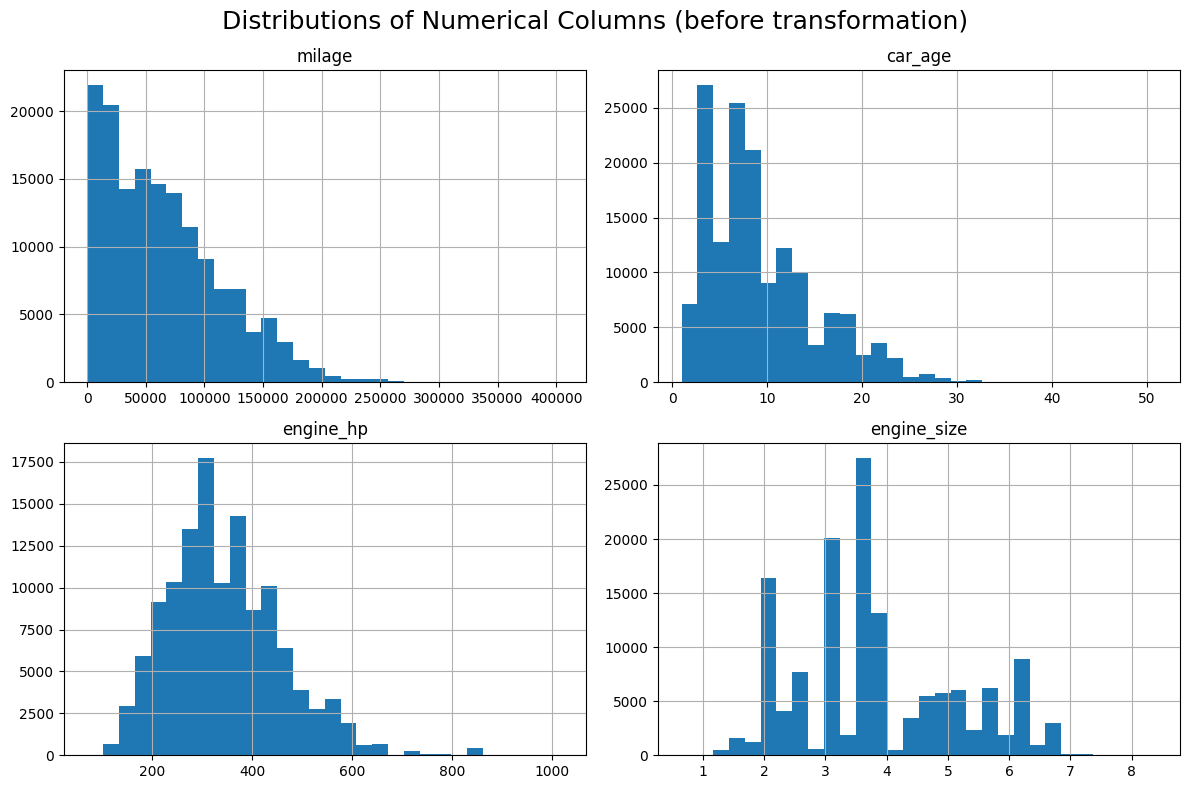

In [77]:
# Plot distributions of numeric features
X_train[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distributions of Numerical Columns (before transformation)", fontsize=18)
plt.tight_layout()
plt.show()

**Observations from distributions and summary stats:**

* `milage` is highly right-skewed. Most values are under 100,000 (75th percentile: 95,000), but a few extreme outliers go up to 400,000. As shown in the `describe()` output, the mean (67,505) is much higher than the median (57,785), confirming skew.

* `car_age` is also right-skewed, peaking around 5–10 years (75th percentile: 12), but some cars go up to 51 years.

* `engine_hp` looks almost bell-shaped but slightly skewed right. Mean is 343, median is 329, and outliers go beyond 1000.

* `engine_size` is multi-modal, with peaks at common engine sizes like 2.0L, 3.0L, 4.0L.

#### Detect outliers

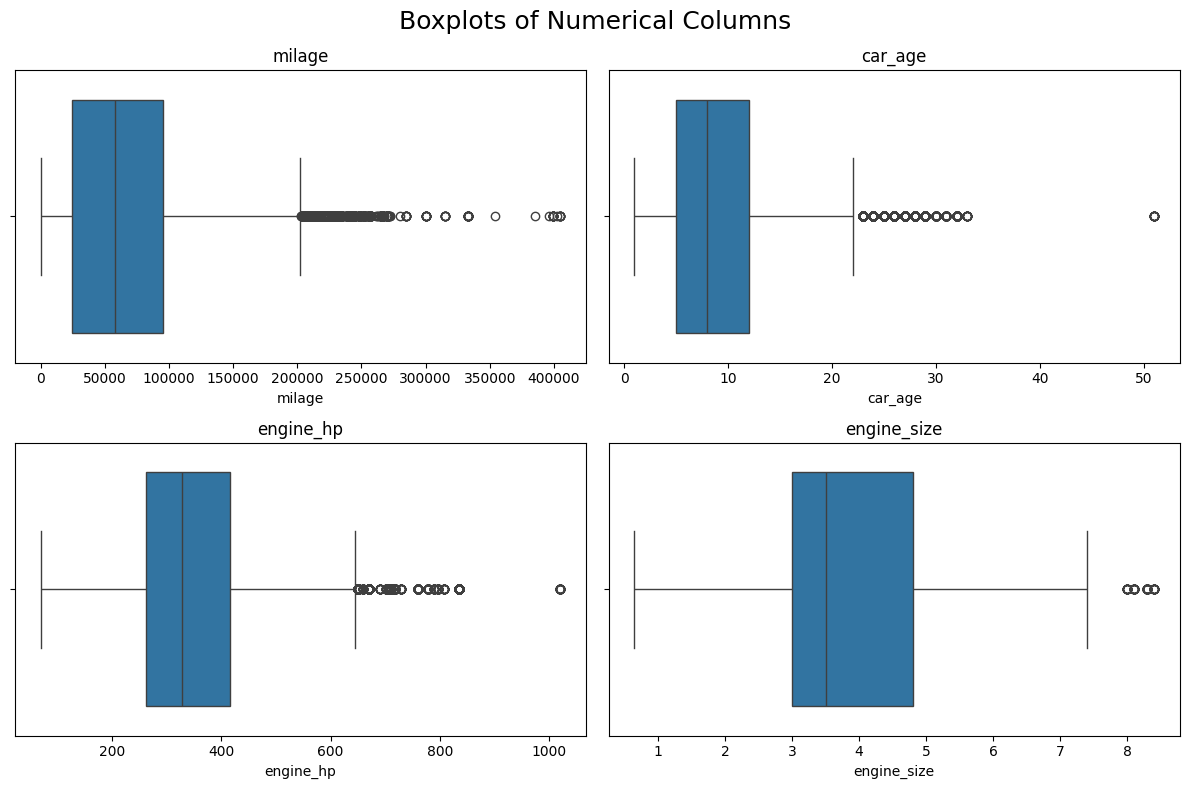

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=X_train[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)): 
    axes[j].set_visible(False) # set visible to false to hide extra plots

plt.suptitle("Boxplots of Numerical Columns", fontsize=18)
plt.tight_layout()
plt.show()

**Observations from outlier check:**

* `milage` has extreme outliers on the high end. Most cars fall below \~100,000 KM, but some go beyond 300K+. I’ll apply `log1p()` to reduce right skew and compress the extreme values.

* `car_age` shows a clean spread between 0 and 20, but a few cars go up to 50 years, which is rare. I’ll keep them and apply `StandardScaler` to normalize the scale.

* `engine_hp` has some visible high-end outliers beyond 600 HP. I’ll use `RobustScaler` to reduce the influence of those extremes.

* `engine_size` doesn’t have sharp outliers but shows a few cars >7L, which are uncommon. I’ll apply `StandardScaler` to keep scaling consistent across numeric features.


In [79]:
X_train.isna().sum()

brand               0
model               0
milage              0
fuel_type           0
engine              0
transmission        0
ext_col             0
int_col             0
accident            0
clean_title         0
car_age             0
brand_grp           0
model_base          0
mdl_grp             0
engine_hp       26611
engine_size     11309
trn_grp             0
ext_col_grp         0
int_col_grp         0
dtype: int64

In [80]:
X_test.isna().sum()

brand              0
model              0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
car_age            0
brand_grp          0
model_base         0
mdl_grp            0
engine_hp       6647
engine_size     2905
trn_grp            0
ext_col_grp        0
int_col_grp        0
dtype: int64

In [81]:
X_train[['engine_hp', 'engine_size']].isna().mean()

engine_hp      0.176436
engine_size    0.074981
dtype: float64

**Strategy to handle missing values:**

Before applying scaling transformations, I checked for missing values in the two numerical columns: `engine_hp` and `engine_size`. The proportions of missing data were:

*   engine_hp: 17.6% missing

*   engine_size: 7.5% missing

Given the relatively small-to-moderate missingness and the fact that both features are continuous with visible outliers, I used the `median` for imputation.
This is because:

*   `Median` is robust to extreme values and skewed distributions.
*   It avoids distortion of scaling results from outlier-influenced means.

I will impute missing values before scaling to ensure the transformations work on complete data.

#### Apply transformation on features

In [82]:
# Create a copy of X_train
X_train_transformed = X_train.copy()

# Log-transform milage
X_train_transformed['milage_log'] = np.log1p(X_train_transformed['milage'])

# Scale car_age using StandardScaler
car_age_scaler = StandardScaler()
X_train_transformed['car_age_scaled'] = car_age_scaler.fit_transform(X_train_transformed[['car_age']])

# Impute missing values before scaling
X_train_transformed['engine_hp'] = X_train_transformed['engine_hp'].fillna(X_train_transformed['engine_hp'].median())
X_train_transformed['engine_size'] = X_train_transformed['engine_size'].fillna(X_train_transformed['engine_size'].median())

# Scale engine_hp using RobustScaler
engine_hp_scaler = RobustScaler()
X_train_transformed['engine_hp_scaled'] = engine_hp_scaler.fit_transform(X_train_transformed[['engine_hp']])

# Scale engine_size using StandardScaler
engine_size_scaler = StandardScaler()
X_train_transformed['engine_size_scaled'] = engine_size_scaler.fit_transform(X_train_transformed[['engine_size']])

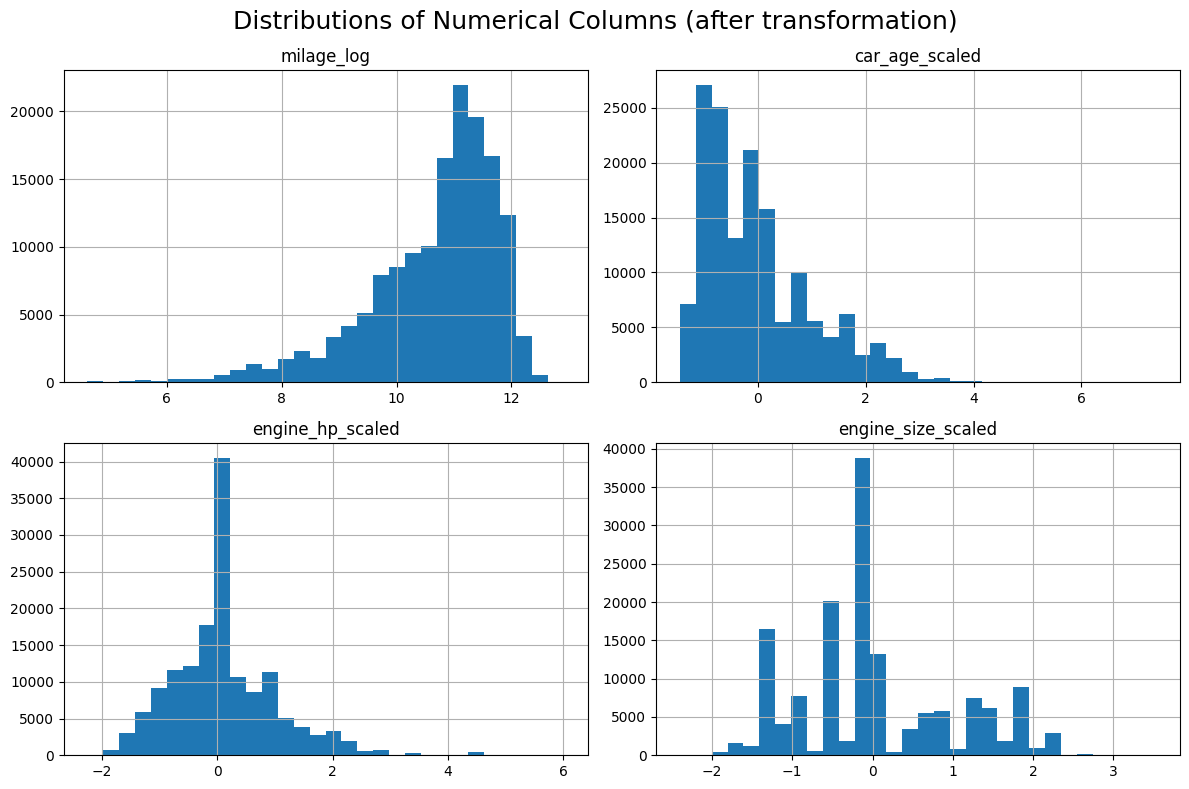

In [83]:
# Verify again
log_cols = [c for c in X_train_transformed.columns if c.endswith(('_log', '_scaled'))]

X_train_transformed[log_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distributions of Numerical Columns (after transformation)", fontsize=18)
plt.tight_layout()
plt.show()

**Observation**

Based on the transformation histograms, I can see that:

* `milage_log` is still slightly right-skewed even after transformation, but it looks much more compressed than before. I’ll keep the log-transformed version for modeling.

* `car_age_scaled` still has some right skew, but the scale is now standardized. I’ll use this version since no other transformation is needed.

* `engine_hp_scaled`already had a near-normal shape before. Scaling mostly adjusted the scale without changing the distribution much. I’ll keep the scaled version as-is.

* `engine_size_scaled` still shows a multi-peak pattern, but scaling has brought the values onto a consistent scale. I’ll use this version for modeling too.

#### Apply same imputation and transformation on X_test

In [84]:
# Create a copy of X_test
X_test_transformed = X_test.copy()

# Log-transform mileage
X_test_transformed['milage_log'] = np.log1p(X_test_transformed['milage'])

# Impute missing values using training medians
X_test_transformed['engine_hp'] = X_test_transformed['engine_hp'].fillna(X_train_transformed['engine_hp'].median())
X_test_transformed['engine_size'] = X_test_transformed['engine_size'].fillna(X_train_transformed['engine_size'].median())

# Apply same scalers from training set
X_test_transformed['car_age_scaled'] = car_age_scaler.transform(X_test_transformed[['car_age']])
X_test_transformed['engine_hp_scaled'] = engine_hp_scaler.transform(X_test_transformed[['engine_hp']])
X_test_transformed['engine_size_scaled'] = engine_size_scaler.transform(X_test_transformed[['engine_size']])

## 2. Exploratory Data Analysis

### 2.1 Visualize Price Distribution, Correlations, and Key Relationships

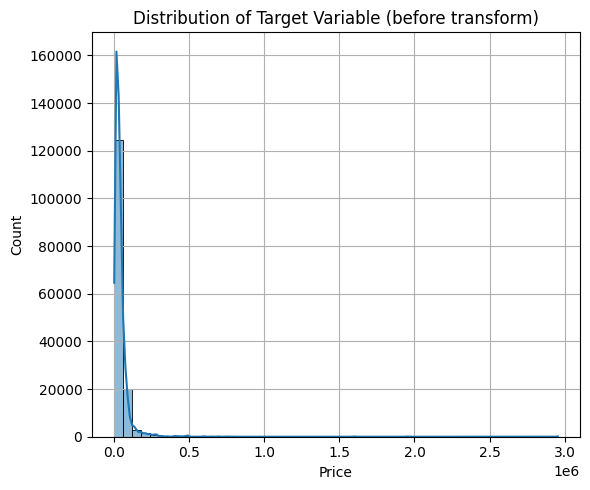

In [85]:
# Plot Distribution before transform
plt.figure(figsize=(6, 5))
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribution of Target Variable (before transform)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation of price distribution:**

* The target variable `price` is highly right-skewed. 

* Most values are concentrated under 100k, with a long tail reaching close to 3 million. 

* This kind of distribution can throw off regression models due to extreme outliers. 

* That's why I will apply `log1p()` transformation to reduce skewness and stabilize variance.

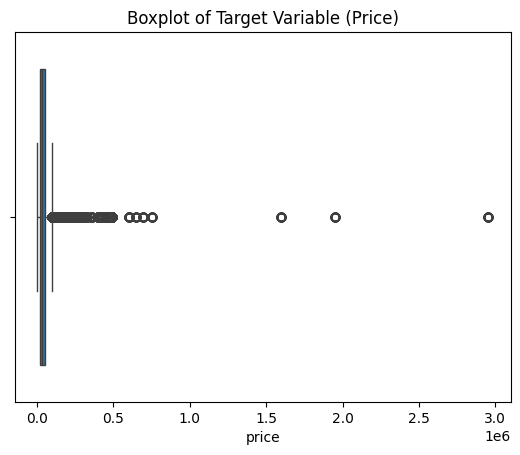

In [86]:
# Plot boxplot to check outliers
sns.boxplot(x=train_df['price'])
plt.title("Boxplot of Target Variable (Price)")
plt.show()

In [87]:
# Check number of price outliers
q1 = train_df['price'].quantile(0.25)
q3 = train_df['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = train_df[train_df['price'] > upper_bound]
print(f"Number of high-end price outliers: {len(outliers)}")

Number of high-end price outliers: 10880


**Observation from outlier detection**

* `price` is heavily right-skewed with a long tail toward high values.

* Boxplot shows several extreme high-end values well beyond the typical range.

* Using IQR method, I found 10,880 high-end outliers above the upper bound.

* These outliers likely include luxury or rare vehicles with unusually high prices.

* I will apply `log1p()` transformation on `price` to reduce skew and minimize the impact of these extremes during modeling.


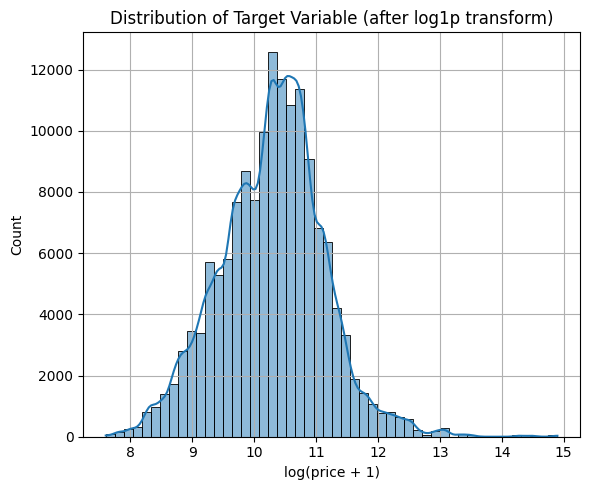

In [88]:
# Apply log1p transformation to target
y_train_scaled = np.log1p(y_train)

# Plot Distribution after tranform
plt.figure(figsize=(6, 5))
sns.histplot(y_train_scaled, bins=50, kde=True)
plt.title("Distribution of Target Variable (after log1p transform)")
plt.xlabel("log(price + 1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation of price distribution after log1p transformation:**

* After applying log1p, the distribution of the target variable looks much more normalized. 

* The extreme right skew in raw price is gone, and now most values are clustered closer to the center. 

* This should help models like linear regression capture the pattern better.

In [89]:
# Apply log1p transformation to y_test
y_test_scaled = np.log1p(y_test)

In [90]:
# Define the final numeric columns
final_numeric_cols = ['milage_log', 'car_age_scaled', 'engine_hp_scaled', 'engine_size_scaled']

# Combine into final
X_train_final = pd.concat([X_train_encoded_df.reset_index(drop=True),
                           X_train_transformed[final_numeric_cols].reset_index(drop=True)],
                          axis=1)

# Verify the dataframe
X_train_final.head()

,fuel_type_e85 flex fuel,fuel_type_gasoline,fuel_type_hybrid,fuel_type_plug-in hybrid,accident_none,accident_reported,clean_title_yes,trn_grp_automatic,trn_grp_cvt,trn_grp_manual,...,engine_cyl_4,engine_cyl_5,engine_cyl_6,engine_cyl_8,engine_cyl_10,engine_cyl_12,milage_log,car_age_scaled,engine_hp_scaled,engine_size_scaled
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,11.029650,-0.208146,-1.052174,-1.365484
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,12.128117,2.264445,-0.782609,0.164878
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,11.429555,-0.737987,-0.034783,-0.829857
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.075195,0.851536,0.000000,-0.217713
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,8.517393,-1.267828,3.373913,1.848275


In [91]:
# Do the same thing for X_test
X_test_final = pd.concat([X_test_encoded_df.reset_index(drop=True),
                          X_test_transformed[final_numeric_cols].reset_index(drop=True)],
                         axis=1)

# Verify the dataframe
X_test_final.head()

,fuel_type_e85 flex fuel,fuel_type_gasoline,fuel_type_hybrid,fuel_type_plug-in hybrid,accident_none,accident_reported,clean_title_yes,trn_grp_automatic,trn_grp_cvt,trn_grp_manual,...,engine_cyl_4,engine_cyl_5,engine_cyl_6,engine_cyl_8,engine_cyl_10,engine_cyl_12,milage_log,car_age_scaled,engine_hp_scaled,engine_size_scaled
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,10.868587,-0.208146,1.008696,0.470950
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,11.097425,-0.208146,0.000000,-0.600303
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.605021,-0.561373,0.000000,-0.141195
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,10.239996,-0.031532,1.052174,-0.217713
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,10.185692,-0.914600,-0.704348,-1.365484


In [92]:
# Add the target for corr analysis
X_train_final_with_target = X_train_final.copy()
X_train_final_with_target['price_log'] = y_train_scaled.reset_index(drop=True)

# Compute correlations
corr_matrix = X_train_final_with_target.corr().abs()

# Get correlation with target
target_corr = corr_matrix['price_log'].sort_values(ascending=False).drop('price_log')

In [93]:
# Print top positive and top negative correlations
print(target_corr.head(15))
print("--------------------")
print(target_corr.tail(15))

car_age_scaled               0.665163
milage_log                   0.636728
engine_hp_scaled             0.479997
accident_reported            0.296064
accident_none                0.281431
engine_cyl_4                 0.216300
clean_title_yes              0.199236
int_col_grp_gray             0.193409
int_col_grp_beige            0.174224
engine_size_scaled           0.157537
int_col_grp_black            0.146465
brand_grp_porsche            0.122878
trn_grp_manual               0.121966
mdl_grp_corvette stingray    0.107068
engine_cyl_6                 0.106540
Name: price_log, dtype: float64
--------------------
mdl_grp_silverado 1500        0.006039
engine_cyl_10                 0.005803
brand_grp_chevrolet           0.005765
engine_cyl_3                  0.005385
mdl_grp_suburban lt           0.004550
mdl_grp_rover discovery       0.004432
brand_grp_audi                0.004283
mdl_grp_sl-class sl           0.003657
brand_grp_ford                0.003630
mdl_grp_wrangler unlimited

In [94]:
# Get top features top_features = target_corr.abs().sort_values(ascending=False).head(20).index.tolist()
top_20_corr_values = target_corr.abs().sort_values(ascending=False).head(20)
top_20_features = top_20_corr_values.index.tolist()

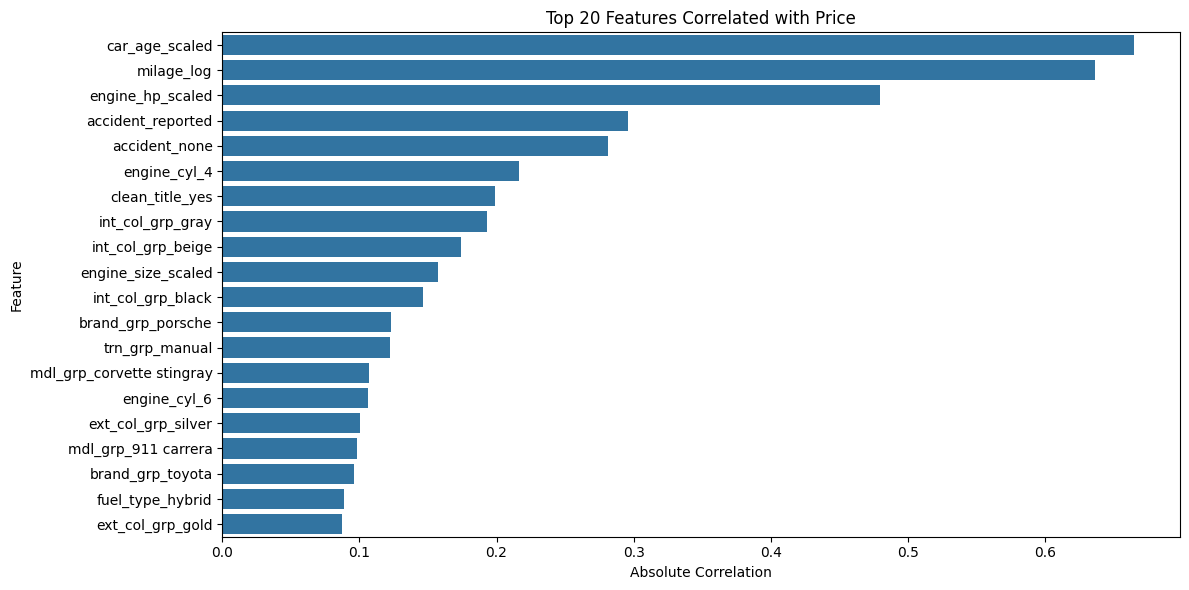

In [95]:
# Plot top 20 features correlated with Price
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_corr_values,
            y=top_20_features)
plt.title("Top 20 Features Correlated with Price")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Observation from Feature Correlation with Price**

* This chart shows the top 20 features with the highest absolute correlation to `price_log`, regardless of direction.

* Features like `car_age_scaled`, `milage_log`, and `engine_hp_scaled` are most strongly correlated with price.

* These variables are likely important predictors, though I can’t infer if they increase or decrease price just from this chart.

* To understand the direction of impact, I plotted a heatmap in the next step using the correlation matrix.

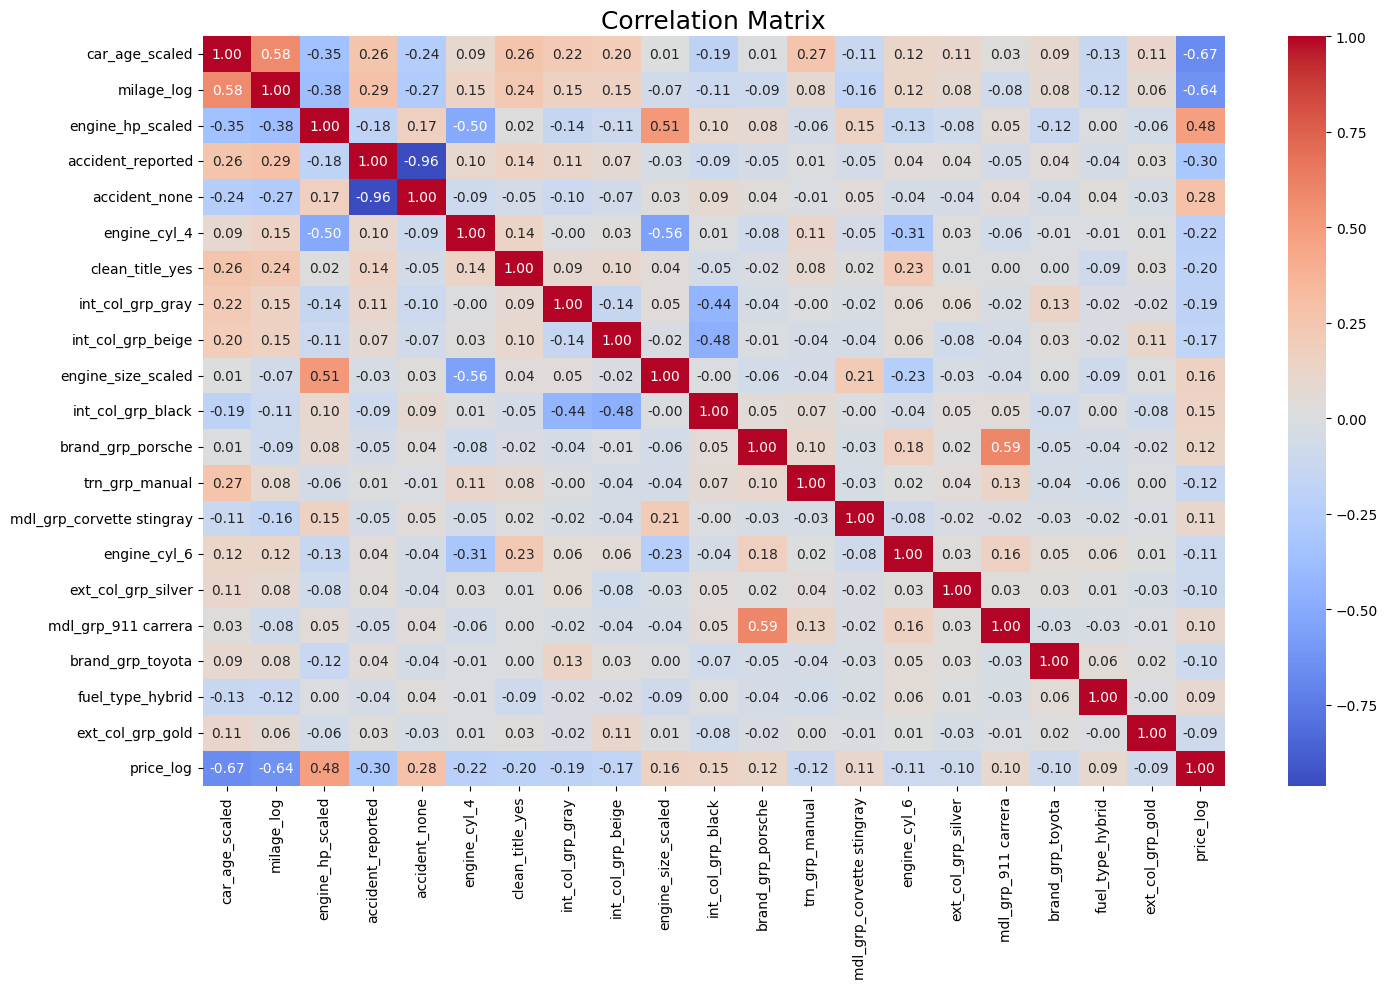

In [96]:
# Create a subset dataframe using top 20 features
top20_corr_df = X_train_final_with_target[top_20_features + ['price_log']]

# Plot heatmap
plt.figure(figsize=(15,10))
sns.heatmap(top20_corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix", fontsize=18)
plt.tight_layout()
plt.show()

**Observations from correlation matrix**

Based on the updated correlation matrix, 

* I can clearly see how some features are strongly associated with the target variable `price_log`:

  * `car_age_scaled` and `milage_log` are **strongly negatively** correlated with `price_log` (–0.68 and –0.63), meaning older or more driven cars tend to be cheaper.

  * `engine_hp_scaled` shows a **strong positive** correlation with `price_log` (0.54), which makes sense since high-performance cars usually cost more.

  * `accident_reported` is negatively correlated (–0.30), while `accident_none` is positively correlated (0.28), showing price differences based on accident history.

* `clean_title_yes` shows a negative correlation of –0.20, indicating that vehicles without clean titles might be priced slightly higher.

* Engine cylinder counts (`engine_cyl_4`: –0.22, `engine_cyl_6`: –0.10) are negatively correlated, suggesting smaller engines are more common in lower-priced models.

* Other features like `fuel_type_hybrid`, `brand_grp_toyota`, or `ext_col_grp_gold` have very low correlations (< 0.10) and may be less useful for prediction.

* There are moderately correlated feature pairs like `car_age_scaled` and `milage_log` (0.58), and `engine_hp_scaled` and `engine_size_scaled` (0.61).

**Strategy**

* Since no feature pair exceeds 0.90, I won’t drop any features at this stage.

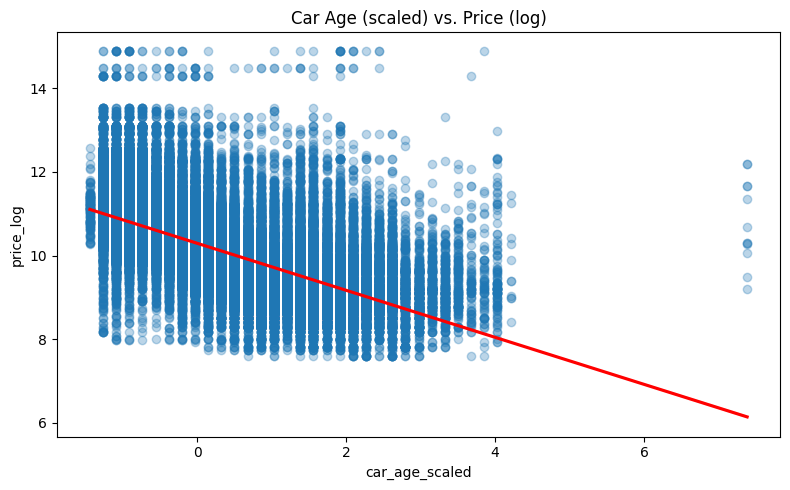

In [97]:
# Check key relationships between car_age_scaled and price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='car_age_scaled', y='price_log', scatter_kws={'alpha': 0.3}, line_kws={"color": "red"})
plt.title("Car Age (scaled) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from Car Age vs. Price**

* Based on the regression plot, there is a clear downward trend where the red line confirms that `price_log` decreases as `car_age_scaled` goes up.

* Newer cars (lower age) generally have higher prices.

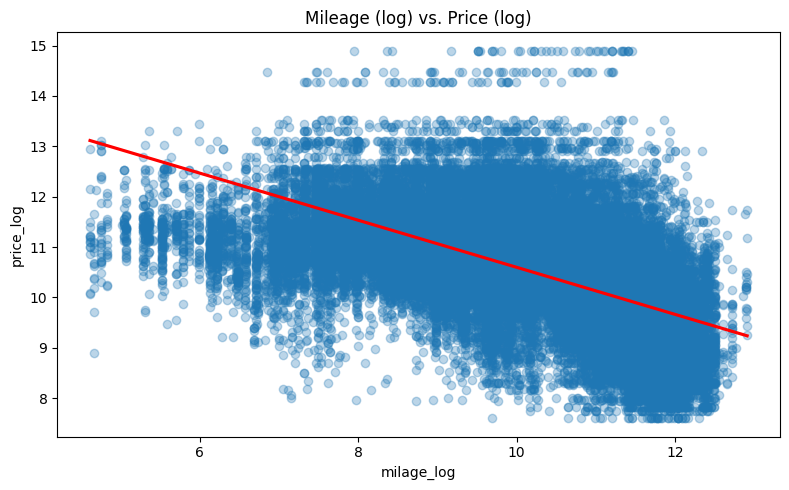

In [98]:
# Check key relationships between milage_log and price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='milage_log', y='price_log', scatter_kws={'alpha': 0.3}, line_kws={"color": "red"})
plt.title("Mileage (log) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observations from Mileage vs. Price**

* Based on the regression plot, I can see the trend where `milage_log` increases, `price_log` generally decreases.

* This confirms a clear negative relationship since higher mileage cars are usually cheaper.

### 2.2 Boxplots for Categorical Features vs. `selling_price`

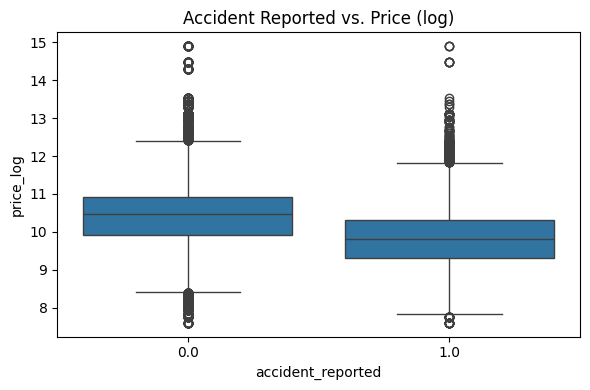

In [99]:
# Plot boxplot to check accident_reported vs price_log
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train_final_with_target, x='accident_reported', y='price_log')
plt.title("Accident Reported vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from Accident Reported vs. Price (log):**

* Based on the boxplot, cars with a reported accident (1.0) tend to have slightly lower log-transformed prices compared to those without accidents (0.0).

* The median price is visibly lower for accident-reported vehicles, suggesting accident history negatively impacts price.

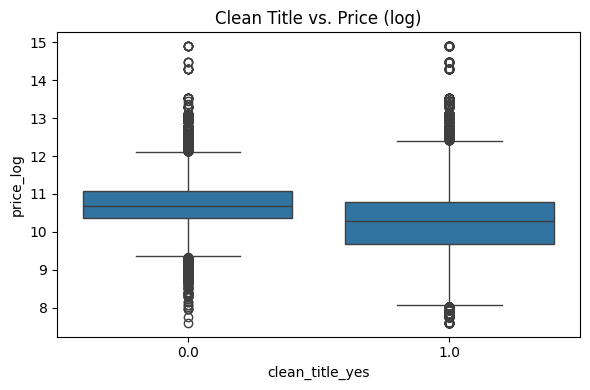

In [100]:
# Plot boxplot to check clean_title_yes vs. price_log
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train_final_with_target, x='clean_title_yes', y='price_log')
plt.title("Clean Title vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from Clean Title vs. Prcie:**

* Based on the boxplot, cars with clean titles (clean_title_yes = 1) tend to have slightly lower price_log than those without.

* This is unexpected since normally, a clean title should boost the price.

* It can be either due to other factors (like brand or condition) that are driving up the prices of non-clean-title cars.

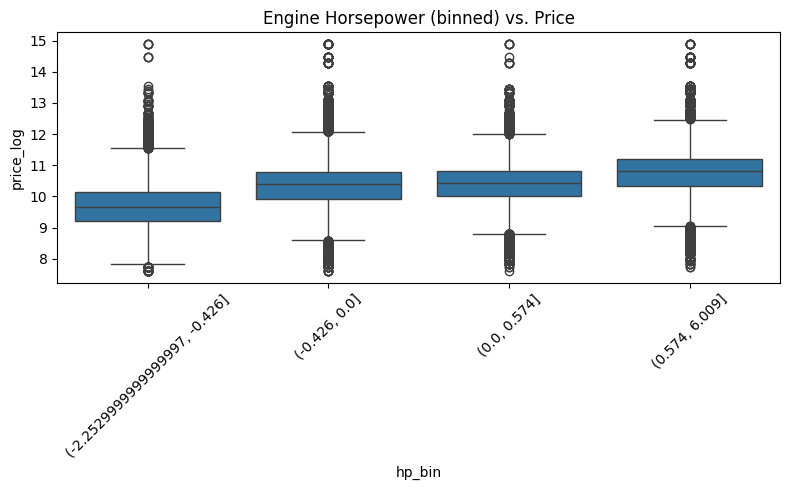

In [101]:
# Bin the scaled horsepower for grouping
X_train_final_with_target['hp_bin'] = pd.qcut(X_train_final_with_target['engine_hp_scaled'], q=4)

# Plot boxplot to compare price distribution across binned engine horsepower levels
plt.figure(figsize=(8, 5))
sns.boxplot(data=X_train_final_with_target, x='hp_bin', y='price_log')
plt.xticks(rotation=45)
plt.title("Engine Horsepower (binned) vs. Price")
plt.tight_layout()
plt.show()

**Observations from Engine Horsepower vs. Price:**

* Base on the boxplot, `engine_hp` goes up, the median price_log also increases. This means higher horsepower generally leads to higher price.

* The price spread (variation) is wider in the higher hp bins.

* This supports the earlier correlation: `engine_hp_scaled` has a positive correlation (~0.54) with `price_log`.

### 2.3 Histograms and Scatter Plots for Numerical Features

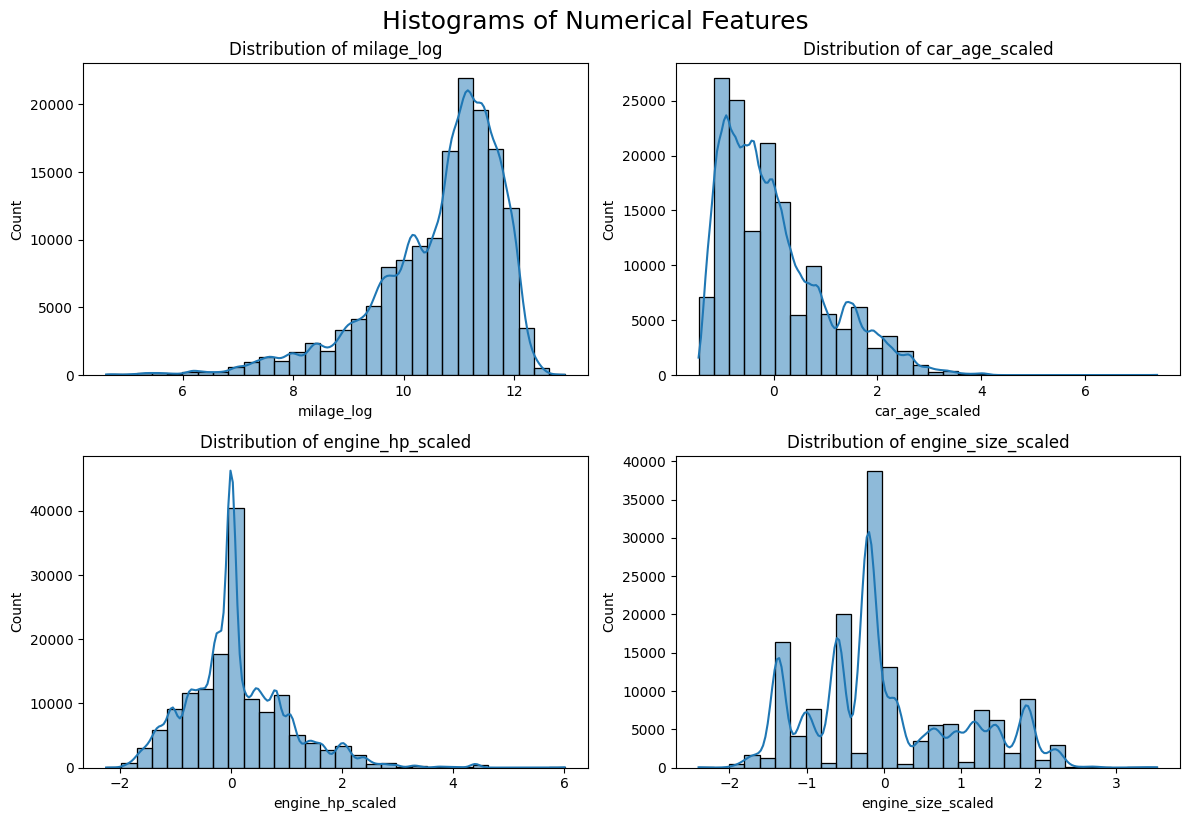

In [102]:
# Select numeric columns excluding binary/dummy features
numeric_cols = ['milage_log', 'car_age_scaled', 'engine_hp_scaled', 'engine_size_scaled']

# Set layout
n_cols = 2
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(numeric_cols):
    sns.histplot(data=X_train_final_with_target, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide unused axes
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.suptitle("Histograms of Numerical Features", fontsize=18, y=1.02)
plt.show()


**Observation from distribution of numeric features:**

Based on the histogram, 

* `milage_log` is right-skewed even after log transformation. Most cars have mileage between 10 and 12 (log scale), indicating high mileage overall.

* `car_age_scaled` is also right-skewed. The majority of cars are relatively new, with a peak around lower age values.

* `engine_hp_scaled` shows a nearly normal distribution but with slight skew and multiple peaks, possibly due to different engine configurations.

* `engine_size_scaled` appears multi-modal with distinct spikes, suggesting common engine sizes (e.g., 2.0L, 3.0L) that dominate the dataset.

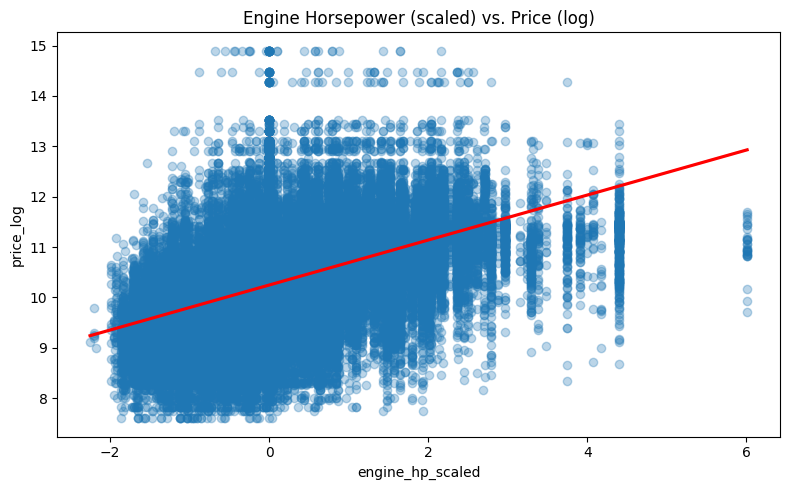

In [103]:
# Plot scatterplot for engine_hp_scaled vs price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='engine_hp_scaled', y='price_log',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title("Engine Horsepower (scaled) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from scatter plot of engine_hp_scaled vs price_log**:

* Based on the scatter plot and regression line, there is a clear positive relationship. As `engine_hp_scaled` increases, `price_log` also tends to rise.

* This is true since horsepower cars are generally priced higher, though there is still some spread due to other influencing factors.

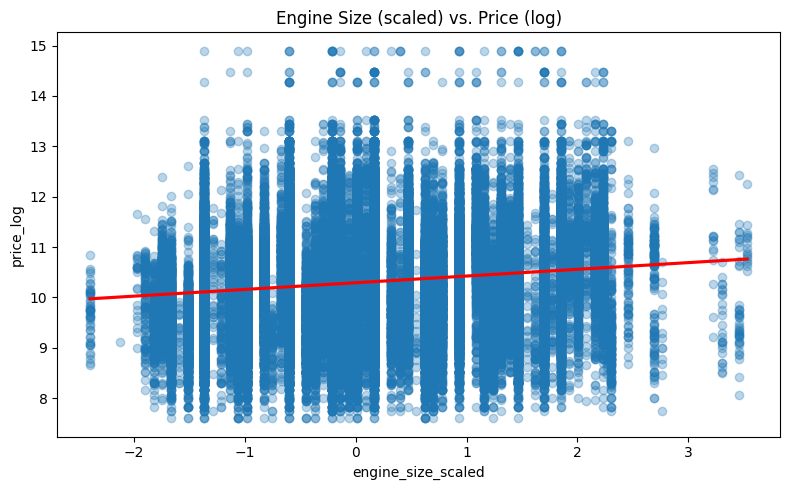

In [104]:
# Plot scatterplot for engine_size_scaled vs price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='engine_size_scaled', y='price_log',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title("Engine Size (scaled) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from sactter plot of engine_size_scaled vs price_log**

* Based on the scatter plot and regression line, there is a mild positive relationship. As `engine_size_scaled` increases, `price_log` tends to rise slightly.

* The upward trend suggests that larger engines are generally associated with higher prices, but the pattern is more dispersed compared to horsepower.

## 3. Model Building

In [105]:
# Replace white spaces in column names
X_train_final.columns = X_train_final.columns.str.replace(' ', '_')
X_test_final.columns = X_test_final.columns.str.replace(' ', '_')

In [106]:
print(X_train_final.shape)
print(X_test_final.shape)
print(y_train_scaled.shape)
print(y_test_scaled.shape)

(150825, 163)
(37707, 163)
(150825,)
(37707,)


In [111]:
# Fit PCA without limiting components
pca = PCA(random_state=42)
pca.fit(X_train_final)

# Get cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain >= 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

Number of components explaining 95% variance: 54


In [112]:
# Reduce dimensionality to 54 principal components
pca = PCA(n_components=54, random_state=42)
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)

print(X_train_pca.shape, X_test_pca.shape)

(150825, 54) (37707, 54)


### 3.1 Linear Regression

In [113]:
# Initialize LinearRegression
lr = LinearRegression()

# Train the model
lr.fit(X_train_pca, y_train_scaled)

# Predict on train and test sets
y_train_pred_lr = lr.predict(X_train_pca)
y_test_pred_lr = lr.predict(X_test_pca)

### 3.2 Ridge Regression

In [114]:
# Initialize Ridge Regression
ridge = Ridge(alpha=1.0)

# Train the model
ridge.fit(X_train_pca, y_train_scaled)

# Predict on train and val sets
y_train_pred_ridge = ridge.predict(X_train_pca)
y_test_pred_ridge = ridge.predict(X_test_pca)

### 3.3 Random Forest Regressor

In [115]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# Train the model
rf.fit(X_train_pca, y_train_scaled)

# Predict on train and val sets
y_train_pred_rf = rf.predict(X_train_pca)
y_test_pred_rf = rf.predict(X_test_pca)

### 3.4 XGBoost Regressor (Optional: use LightGBM or any other advanced model)

In [117]:
# Initialize XGBRegressor
xgb = XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train the model
xgb.fit(X_train_pca, y_train_scaled)

# Predict on train and val sets
y_train_pred_xgb = xgb.predict(X_train_pca)
y_test_pred_xgb = xgb.predict(X_test_pca)

### 3.5 LightGBM Regressor

In [118]:
# Initialize LightGBM Regressor
lgbm = LGBMRegressor(n_estimators=50, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train the model
lgbm.fit(X_train_pca, y_train_scaled)

# Predict on train and val sets
y_train_pred_lgbm = lgbm.predict(X_train_pca)
y_test_pred_lgbm = lgbm.predict(X_test_pca)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13770
[LightGBM] [Info] Number of data points in the train set: 150825, number of used features: 54
[LightGBM] [Info] Start training from score 10.291456


## 4. Model Evaluation

### 4.1 Evaluate each model using:
- R² Score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

In [119]:
# Define function to evaluate models
def evaluate_model(y_true, y_pred, model_name, dataset):

    # Get r2 score
    r2 = r2_score(y_true, y_pred)

    # Get mae
    mae = mean_absolute_error(y_true, y_pred)

    # Get rmse
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Print model name, dataset, and corresponding metrics
    print(f"{model_name} ({dataset} set):")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}\n")

In [120]:
# Evaluate all models
models = {
    "Linear Regression": lr,
    "Ridge Regression": ridge,
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

# Loop though models
for name, model in models.items():

    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)

    evaluate_model(y_train_scaled, y_train_pred, name, "Train")
    evaluate_model(y_test_scaled, y_test_pred, name, "Test")

Linear Regression (Train set):
  R² Score: 0.5999
  MAE: 0.3803
  RMSE: 0.5344

Linear Regression (Test set):
  R² Score: 0.5917
  MAE: 0.3820
  RMSE: 0.5379

Ridge Regression (Train set):
  R² Score: 0.5999
  MAE: 0.3803
  RMSE: 0.5344

Ridge Regression (Test set):
  R² Score: 0.5917
  MAE: 0.3820
  RMSE: 0.5379

Random Forest (Train set):
  R² Score: 0.9435
  MAE: 0.1407
  RMSE: 0.2007

Random Forest (Test set):
  R² Score: 0.6108
  MAE: 0.3722
  RMSE: 0.5252

XGBoost (Train set):
  R² Score: 0.6628
  MAE: 0.3471
  RMSE: 0.4906

XGBoost (Test set):
  R² Score: 0.6385
  MAE: 0.3549
  RMSE: 0.5062

LightGBM (Train set):
  R² Score: 0.6541
  MAE: 0.3513
  RMSE: 0.4968

LightGBM (Test set):
  R² Score: 0.6366
  MAE: 0.3562
  RMSE: 0.5074



**Insights from Model Performance Summary:**

* `Linear Regression` and `Ridge` give identical results. Both models perform similarly on train and test sets with R² around 0.61, MAE 0.37, and RMSE 0.53. No benefit from regularization here.

* `Random Forest` shows **clear overfitting**. R² jumps to 0.94 on train but drops to 0.62 on test. MAE and RMSE are much lower on train than test. Model memorized train data too well.

* `XGBoost` performs better since it generalizes well with R² 0.67 train and 0.65 test. Error metrics are also more consistent between sets.

* `LightGBM` gives similar results to XGBoost, with slightly lower train R², but test performance is almost the same, suggesting it generalizes just as well.

* To conclude, `XGBoost` and `LightGBM` are the best models here. They offer a good balance between learning and generalization. `Random Forest` is strong on train but overfits. `Ridge` and `Linear Regression` underfit and lack flexibility.

### 4.2 Use cross-validation (e.g., 5-fold) to ensure generalization.

In [121]:
# Define models to cross-validate
cv_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Define scoring keys
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

# Display names for final table
display_names = {
    'r2': 'R²',
    'neg_mean_absolute_error': 'MAE',
    'neg_root_mean_squared_error': 'RMSE'
}

# Run cross-validation
cv_results = {}
for name, model in cv_models.items():
    scores = cross_validate(model, X_train_pca, y_train_scaled, cv=5, scoring=scoring, n_jobs=-1)
    cv_results[name] = {
        display_names[score]: (
            scores[f'test_{score}'].mean() if 'neg_' not in score else -scores[f'test_{score}'].mean()
        )
        for score in scoring
    }

# Display
cv_df = pd.DataFrame(cv_results).T.round(4)
cv_df = cv_df[['R²', 'MAE', 'RMSE']]
print(cv_df)

                       R²     MAE    RMSE
Linear Regression  0.5995  0.3805  0.5346
Ridge Regression   0.5995  0.3805  0.5346
Random Forest      0.6253  0.3673  0.5171
XGBoost            0.6419  0.3564  0.5055
LightGBM           0.6480  0.3530  0.5012


## 5. Model Selection

### 5.1 Select the best model based on lowest RMSE and highest R².

In [122]:
# Find the best model based on lowest RMSE
best_model_name = cv_df['RMSE'].idxmin()
best_model = cv_models[best_model_name]

print("Best model based on RMSE:", best_model_name)

Best model based on RMSE: LightGBM


### 5.2 Show a comparison table for model performance.

In [123]:
# Display comparison table
print(cv_df)

                       R²     MAE    RMSE
Linear Regression  0.5995  0.3805  0.5346
Ridge Regression   0.5995  0.3805  0.5346
Random Forest      0.6253  0.3673  0.5171
XGBoost            0.6419  0.3564  0.5055
LightGBM           0.6480  0.3530  0.5012


## 6. Save the Best Model

### 6.1 Use `joblib` or `pickle` to save the best-performing model.

In [124]:
# Save model using pickle
with open(f'best_model_{best_model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## References

* Reade, W. and Chow, A. (2024). Regression of Used Car Prices. [online] Kaggle. Available at: https://www.kaggle.com/competitions/playground-series-s4e9/overview [Accessed 21 Jun. 2025].

* Python Documentation. (2019). datetime — Basic date and time types. [online] Available at: https://docs.python.org/3/library/datetime.html#datetime.date.year [Accessed 16 Jun. 2025].

* Pandas 1.4.1 Documentation. (2025). Options and Settings. [online] Available at: https://pandas.pydata.org/docs/user_guide/options.html [Accessed 16 Jun. 2025].